In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -qq gdrive/My\ Drive/cancer/dataset.zip

In [ ]:
train_path_str = '/content/Data/train'
val_path_str = '/content/Data/valid'
test_path_str = '/content/Data/test'

In [ ]:
test_classes = os.listdir(test_path_str)

In [ ]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

In [ ]:
train_data = trainGenertor.flow_from_directory(
    train_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenertor.flow_from_directory(
    val_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.src.metrics.confusion_metrics import activations
model = Sequential()
model.add(VGG16_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [ ]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [ ]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100
39/39 [==============================] - 29s 333ms/step - loss: 1.6977 - accuracy: 0.3997 - val_loss: 1.5653 - val_accuracy: 0.4583
Epoch 2/100
39/39 [==============================] - 12s 304ms/step - loss: 1.1663 - accuracy: 0.4943 - val_loss: 1.2341 - val_accuracy: 0.4444
Epoch 3/100
39/39 [==============================] - 11s 279ms/step - loss: 1.0661 - accuracy: 0.5155 - val_loss: 1.0697 - val_accuracy: 0.5000
Epoch 4/100
39/39 [==============================] - 11s 280ms/step - loss: 0.9628 - accuracy: 0.5367 - val_loss: 1.1024 - val_accuracy: 0.4861
Epoch 5/100
39/39 [==============================] - 12s 304ms/step - loss: 0.9623 - accuracy: 0.5710 - val_loss: 0.8778 - val_accuracy: 0.5556
Epoch 6/100
39/39 [==============================] - 11s 289ms/step - loss: 0.8312 - accuracy: 0.6215 - val_loss: 0.9801 - val_accuracy: 0.5417
Epoch 7/100
39/39 [==============================] - 11s 278ms/step - loss: 0.8498 - accuracy: 0.6395 - val_loss: 1.0710 - val_accuracy:

In [ ]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)

20/20 [==============================] - 4s 213ms/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       120
           1       0.76      0.92      0.83        51
           2       1.00      0.98      0.99        54
           3       0.94      0.76      0.84        90

    accuracy                           0.88       315
   macro avg       0.89      0.89      0.89       315
weighted avg       0.89      0.88      0.88       315



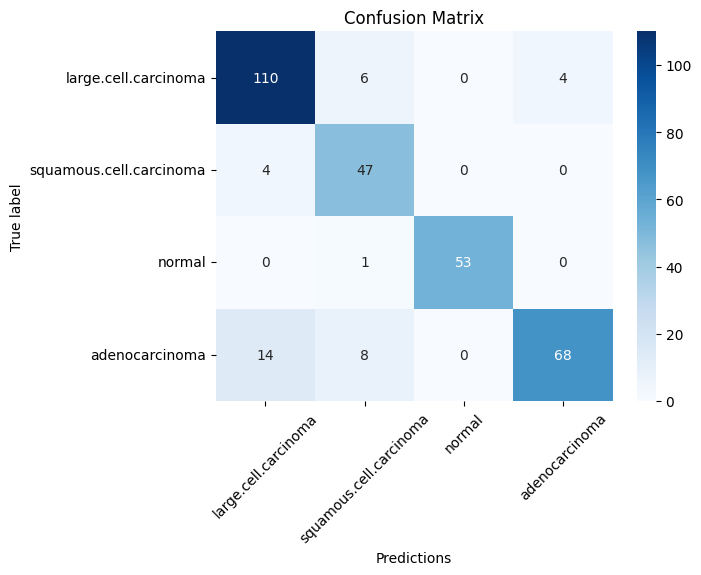

In [ ]:
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()